# Setup and load data:

In [1]:
%load_ext autoreload
%autoreload 2

from functions.functions import *
from functions.plotting import *
from functions.autoencoder import *
from functions.mdn import *
from keras import backend as K
from keras.callbacks import TerminateOnNaN, ModelCheckpoint
from livelossplot.keras import PlotLossesCallback
import livelossplot
import tensorflow as tf
import numpy as np
import os
import glob
from itertools import combinations

Using TensorFlow backend.
W0510 14:02:17.167677 140710859343680 __init__.py:307] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0510 14:02:17.184513 140710859343680 __init__.py:334] Limited tf.summary API due to missing TensorBoard installation.


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [2]:
setup()

GPUs found: 1


In [3]:
data = load_data('data/mariel_*')

['data/mariel_betternot_and_retrograde.npy', 'data/mariel_beyond.npy', 'data/mariel_chunli.npy', 'data/mariel_honey.npy', 'data/mariel_knownbetter.npy', 'data/mariel_penelope.npy']


# Check out the real data:

Starting from frame 32070...


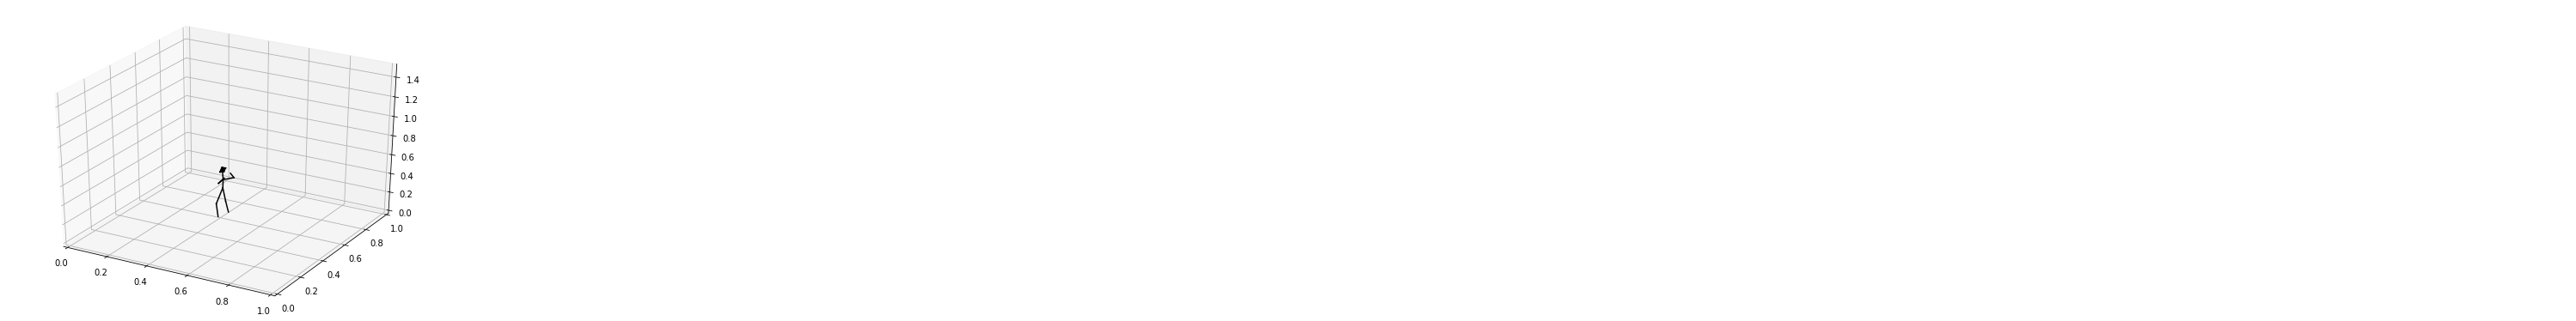

In [7]:
frame = np.random.randint(0,data.full.X.shape[1]-50)
print("Starting from frame {}...".format(frame))

# HTML(animate(data.full.X[:,frame:,:], frames=50))
HTML(animate(data.selected.X[:,frame:,:], frames=50, edges=data.selected.edges, colors='black'))

# Build the vanilla autoencoder for poses

### Define the training dataset:

In [ ]:
X_train = data.selected.X[:,:,:]    # 15 joints
# X_train = data.full.X[:,:,:]    # 55 joints

### Train without adding random (x,y) offsets:

In [ ]:
ae_nooffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_nooffset.model.fit(X_T, X_T, batch_size = 128, epochs = 10)

In [ ]:
# autoencoded prediction in blue, real data in black (we want these to be very similar):
starting_frame = 16600
n_frames = 100
predictions = ae_nooffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

### Train with adding random (x,y) offsets to the input data:

In [ ]:
ae_withoffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_withoffset.model.fit(X_T, X_T, batch_size = 128, epochs = 10)

In [ ]:
# autoencoded prediction in blue, real data in black:
starting_frame = 16600
n_frames = 100
predictions = ae_withoffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

In [ ]:
# # Analyze the autoencoder latent space (with random x,y offsets)
# X = data.selected.X
# encoded = []
# for idx, i in enumerate(range(X.shape[1])):
#   positions = np.expand_dims(X[:,i,:].squeeze(), axis=0)
#   encoded.append( ae_withoffset.encoder.predict(positions) )
#   if idx and idx % 10000 == 0:
#     print(' * processed', idx, 'of', X.shape[1])
# encoded = np.array(encoded).squeeze() # shape = (13463, ae.latent_dim)

# # draw the plot
# fig = plt.figure(figsize=(20, 14))
# ax = p3.Axes3D(fig)
# ax.scatter(encoded[:,0], encoded[:,1], encoded[:,2], depthshade=False, alpha=0.3, s=0.5, c=np.arange(len(encoded)))

# LSTM + MDN

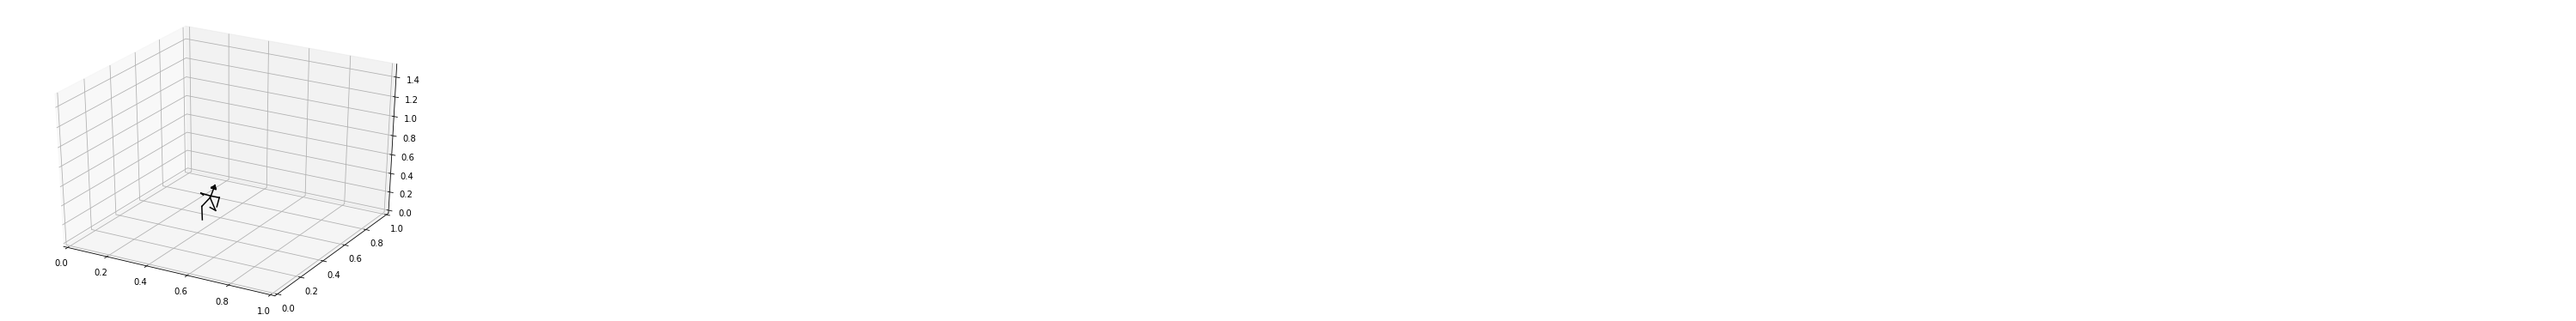

In [10]:
# plot to show x,y centering 
frame = np.random.randint(0,data.full.X.shape[1]-50)
X = data.selected.X # 15 joints
X = X.swapaxes(0, 1)
X[:,:,0] = X[:,:,0] - np.mean(X[:,:,0], axis=0) + 0.5*np.ones(15)
X[:,:,1] = X[:,:,1] - np.mean(X[:,:,1], axis=0) + 0.5*np.ones(15)
HTML(animate(data.selected.X[:,frame:,:], frames=100, edges=data.selected.edges, colors='black'))

In [11]:
X = data.selected.X # 15 joints
n_verts, n_time, n_dims = X.shape
n_mixes = 3
look_back = 10

lstm_mdn = LSTM_MDN(cells = [128,128,128,64], n_verts=n_verts, n_dims=n_dims, n_mixes=n_mixes, look_back=look_back)
train_X, train_Y = lstm_mdn.prepare_inputs(X, look_back=look_back)
lstm_mdn.model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 45)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 10, 128)           89600     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 128)           132096    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
mdn_1 (MDN)                  (None, 64)                9165      
Total params: 371,213
Trainable params: 371,213
Non-trainable params: 

In [ ]:
checkpoint_filepath="lstm_nopca_128_128_128_64_xycentering.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

# Train the model:
lstm_mdn.model.fit(train_X, train_Y, 
                   epochs=20, 
                   batch_size=64, 
                   shuffle=False, 
                   callbacks=[checkpoint, PlotLossesCallback(), TerminateOnNaN()])

In [ ]:
trained_model = lstm_mdn
trained_model.model.load_weights('lstm_nopca_128_128_128_64_xycentering.h5')

### See how well the model can predict the next frame in the input sequence:

In [ ]:
# visualize how well the model learned the input sequence
n_frames = 100 # n frames of time slices to generate
output_dims = train_X.shape[2]
frame = np.random.randint(0,data.full.X.shape[1]-50)
frames = []

test_X = train_X[frame:frame+n_frames] # data to pass into forward prop through the model
y_pred = trained_model.model.predict(test_X) # output with shape (n_frames, (output_dims+2) * n_mixes )

# partition out the mus, sigs, and mixture weights
for i in range(n_frames):
    y = y_pred[i].squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:n_mixes*output_dims + n_mixes]
    alphas = y[-n_mixes:]
    # find the most likely distribution - then disregard that number and use the first Gaussian :)
    alpha_idx = np.argmax(alphas)
    alpha_idx = 0
    # pull out the mus that correspond to the selected alpha index
    positions = mus[alpha_idx * output_dims:(alpha_idx+1) * output_dims]
    frames.append(positions)

frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))
HTML(animate_ghost(data.selected.X[:,frame:,:], lstm_predictions[:,:,:], frames=n_frames, edges=data.selected.edges, colors='blue', ghost_shift = 0.3))

# Now generate new sequences!

In [ ]:
# trained_model.model.predict(train_X).shape

In [ ]:
n_frames = 50 # n frames of time slices to generate
frames = []
seed = 33091
# seed = np.random.randint(0, len(train_X)-1)
x = np.expand_dims(train_X[seed], axis=0)
print(' * seeding with', seed)

for i in range(n_frames):
    y = trained_model.model.predict(x).squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:-n_mixes]
    alphas = softmax(y[-n_mixes:])

    # select the alpha channel to use
    alpha_idx = np.argmax(alphas)

    # grab the mus and sigs associated with the selected alpha_idx
    frame_mus = mus.ravel()[alpha_idx*output_dims : (alpha_idx+1)*output_dims]
    frame_sig = sigs[alpha_idx] / 100

    # now sample from each Gaussian
    positions = [np.random.normal(loc=m, scale=frame_sig) for m in frame_mus]
    positions = frame_mus

    # add these positions to the results
    frames.append(positions)

    # pull out a new training example - stack the new result on
    # all values after the first from the bottom-most value in the x's
    start = x[:,1:,:]
    end = np.expand_dims( np.expand_dims(positions, axis=0), axis=0 )
    x = np.concatenate((start, end), axis=1)
    
frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))

prompt_plus_generated_seq = np.concatenate((data.selected.X[:,seed:seed+10,:],lstm_predictions), axis=1)

# HTML(animate(prompt_plus_generated_seq, frames=n_frames, edges=data.selected.edges, colors='black'))
HTML(animate_ghost(data.selected.X[:,seed:seed+10+n_frames:,:], prompt_plus_generated_seq, frames=n_frames, edges=data.selected.edges, colors='blue'))

NEXT STEPS:
- augment with random rotations